In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from IPython.display import display, clear_output
from matplotlib import colors
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import random
from tqdm import tqdm
import copy
from matplotlib.colors import LightSource
from sklearn.metrics import r2_score, mean_squared_error
from skimage.metrics import structural_similarity as ssim

import alphashape
from shapely.geometry import Point
from scipy.spatial import KDTree
import shapely
from collections import defaultdict
from scipy.interpolate import Akima1DInterpolator as AK1D
from scipy.interpolate import RBFInterpolator as RBF
from scipy.interpolate import CloughTocher2DInterpolator as CT
from tensorweave import *

from sklearn.decomposition import PCA

from scipy.fft import fft2, fftshift, ifft2, ifftshift, fftfreq

def twod_k(inc, x_mesh, y_mesh):

    kx = np.zeros_like(x_mesh)
    ky = np.zeros_like(y_mesh)
    nc = kx.shape[0]
    nr = ky.shape[0]

    pi = np.pi
    td1 = 2 * pi / (inc * (nc - 1))
    td2 = 2 * pi / (inc * (nr - 1))

    for i in range(1, nc // 2 + 1):
        kx[i - 1] = (td1 * (i))

    for j in range(1, nr // 2 + 1):
        ky[j - 1] = (td2 * (j))

    for i in range(nc // 2, nc):
        kx[i] = (td1 * (nc - i))

    for j in range(nr // 2, nr):
        ky[j] = (td2 * (nr - j))

    kx_array, ky_array = np.meshgrid(kx, ky)
    kz_array = np.sqrt(kx_array**2 + ky_array**2)

    return kx_array, ky_array, kz_array

# Sine Activation
class Sine(nn.Module):
    def __init__(self, omega_0=1, is_first=False):
        """
        Sinusoidal activation with frequency scaling.

        Parameters:
            omega_0 (float): Frequency scaling factor. Typical value for hidden layers is 30.
            is_first (bool): If True, no scaling is applied to the input (per SIREN recommendations for the first layer).
        """
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        if self.is_first:
            return torch.cos(input)
        else:
            return torch.cos(self.omega_0 * input)

# Real Gabor Wavelet Activation
class RealGabor(nn.Module):
    '''
        Implicit representation with Gabor nonlinearity
        
        Inputs;
            in_features: Input features
            out_features; Output features
            bias: if True, enable bias for the linear operation
            is_first: Legacy SIREN parameter
            omega_0: Legacy SIREN parameter
            omega: Frequency of Gabor sinusoid term
            scale: Scaling of Gabor Gaussian term
    '''
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega0=10.0, sigma0=10.0,
                 trainable=False):
        super().__init__()
        self.omega_0 = omega0
        self.scale_0 = sigma0
        self.is_first = is_first
        
        self.in_features = in_features
        
        self.freqs = nn.Linear(in_features, out_features, bias=bias)
        self.scale = nn.Linear(in_features, out_features, bias=bias)
        
    def forward(self, input):
        omega = self.omega_0 * self.freqs(input)
        scale = self.scale(input) * self.scale_0
        
        return torch.sin(omega)*torch.exp(-(scale**2))
    
# Plotting params
font_dirs = ['./Lato/',]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs[0], fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Histogram Equalization
def hist_equalize(image, nbins=256, preserve_range=False, mask=None):
    """
    Perform histogram equalization on the input image.
    
    Parameters:
      image (np.ndarray): Input image.
      nbins (int): Number of histogram bins (default: 256).
      preserve_range (bool): If True, scales output back to original intensity range (default: False).
      mask (np.ndarray, optional): Boolean mask to specify which pixels to consider.
      
    Returns:
      np.ndarray: Histogram-equalized image with the same shape as input.
    """
    # Flatten the image; if a mask is provided, only use the masked values.
    if mask is not None:
        flat = image[mask]
    else:
        flat = image.ravel()
    
    # Determine intensity range for the histogram (ignoring masked values if present)
    min_val = np.nanmin(flat)
    max_val = np.nanmax(flat)
    
    # Compute histogram and bin edges
    hist, bin_edges = np.histogram(flat, bins=nbins, range=(min_val, max_val), density=True)
    
    # Compute cumulative distribution function (CDF)
    cdf = hist.cumsum()
    cdf = (cdf - cdf.min()) / (cdf.max() - cdf.min())
    
    # Calculate bin centers for a smoother interpolation.
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Use linear interpolation of the CDF to map the original image pixels.
    equalized = np.interp(image.ravel(), bin_centers, cdf).reshape(image.shape)
    
    # Optionally scale back to the original range.
    if preserve_range:
        equalized = equalized * (max_val - min_val) + min_val
        
    return equalized

def compute_scaling_matrix(points, s):
    """
    Computes a scaling matrix that squishes points in the direction
    perpendicular to the main flight line (determined via PCA).
    
    Args:
        points (np.ndarray): Array of shape (n_points, 2) with your 2D data.
        s (float): Scaling factor for the perpendicular direction (< 1 for compression).
    
    Returns:
        np.ndarray: The 2x2 transformation matrix.
    """
    # Perform PCA to get the principal component (flight line direction)
    pca = PCA(n_components=2)
    pca.fit(points)
    v = pca.components_[1]  # The dominant direction (unit vector by definition)
    
    # Compute the perpendicular direction (rotate by 90 degrees)
    v_perp = np.array([-v[1], v[0]])
    
    # Build the transformation matrix: M = [v, v_perp] * diag(1, s) * [v, v_perp].T
    V = np.column_stack((v, v_perp))
    S = np.diag([1, s])
    M = V @ S @ V.T
    return M

# Plotting params
# RCParams
plt.rcParams["text.usetex"] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.formatter.use_mathtext'] = False
plt.rcParams['font.size'] = 20
plt.rcParams["axes.formatter.limits"] = [-5, 5]

# Set device
device = "cuda"

In [2]:
# High resolution dataset
full_dataset_hr = np.load("hr_data_new_3.npy")
xyz_hr = full_dataset_hr[:, (0, 1, 2)]
g_hr = full_dataset_hr[:, (3, 4, 5)]
ftg_hr = full_dataset_hr[:, 6:]

# Interpolation grid
xvec = xyz_hr[:, 0]
yvec = xyz_hr[:, 1]
zvec = np.ones_like(xyz_hr[:, 2])
grid = np.c_[xvec, yvec, zvec]
actv = np.ones_like(xvec).astype(bool)
shape = (65, 65)
x_mesh = xvec.reshape(shape)[:, 0]
y_mesh = yvec.reshape(shape)[0]

In [3]:
### Read and load the ftg data
full_dataset = np.load("lr_data_new_3_260.npy")
xyz = full_dataset[:, (0, 1, 2)]
xyz[:, -1] = 1.
g = full_dataset[:, (3, 4, 5)]
ftg = full_dataset[:, 6:]
ftg += np.random.randn(ftg.shape[0])[:, None]

In [4]:
# Compute the RBF
rbf_func = RBF(xyz[:, :-1], ftg, neighbors=200, smoothing=5e4)
rbf_grid = np.full((xvec.shape[0], 6), np.nan)
rbf_grid[actv] = rbf_func(grid[actv, :-1])

In [5]:
# Known points (data-fitting targets)
xyz_perturb = np.copy(xyz)
xyz_perturb[:, -1] += np.random.randn(xyz.shape[0])
xyz_torch = torch.tensor(xyz_perturb, device=device, dtype=torch.float32)
b_torch = torch.tensor(ftg[:, (0, 1, 2, 4, 5)], device=device, dtype=torch.float32)  # xx, xy, xz, yy, yz, zz
splitter = torch.mean(torch.abs(b_torch))

# Detect device
tgrid = torch.tensor(grid, dtype=torch.float32, device=device)

# Preload active grid points (for Laplacian loss) on GPU
active_grid_points_np = np.c_[xvec, yvec, zvec][actv]  # shape: (N_active, 3)
active_grid_points = torch.tensor(active_grid_points_np, device=device, dtype=torch.float32)

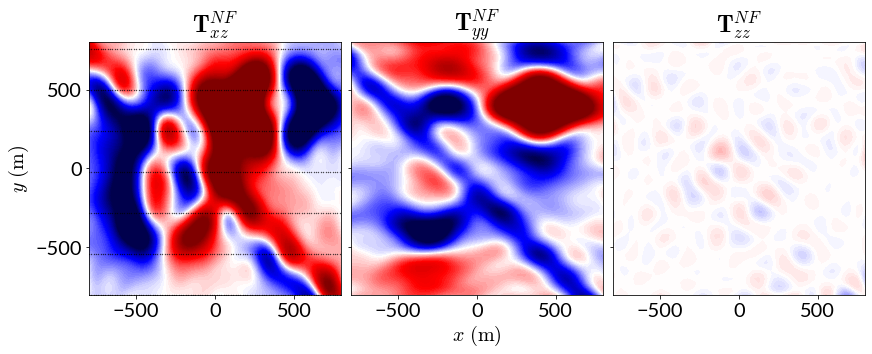

Training:  56%|█████▌    | 559/1000 [02:15<01:47,  4.12it/s, Train Loss=0.111814, LR=8.59e-6, Pat. Ctr=0]


KeyboardInterrupt: 

In [6]:
# Initialise
model = NeuralFourierField(num_fourier_features=64, length_scales=[2e2, 3.7e2, 1e3], decay_scales=[2.9e2, 4e2, 1e3], learnable=True,
                           potential_scale=5e6, device=device, hidden_layers=[1024, 512, 512], activation=nn.Mish(), seed=404, harmonic=True)

# Assume tgrid is defined as a full grid of coordinates for TV loss.
# For example, if xx is an (H, W) meshgrid, then:
# tgrid_np = np.c_[x_mesh.ravel(), y_mesh.ravel(), zvec_full]  # ensure correct shape
# tgrid = torch.tensor(tgrid_np, device=device, dtype=torch.float32)

# -------------------------------------------------------------
# Optimizer, Scheduler, and Loss Function
# -------------------------------------------------------------
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.8,
    patience=10,
    verbose=True
)
loss_fn = nn.L1Loss()

# -------------------------------------------------------------
# Early Stopping Setup
# -------------------------------------------------------------
best_loss = float('inf')
best_model_state = copy.deepcopy(model.state_dict())
patience = 50
no_improve_count = 0

# Loss scalers (initialized on the first epoch)
high_grad_scaler, low_grad_scaler, div_scaler, lap_scaler, curv_scaler = None, None, None, None, None

# Number of Laplacian sample points (use up to 2048 points)
n_lap_samples = min(2000, tgrid.shape[0])

max_epochs = 1000

# -------------------------------------------------------------
# Training Loop (with separate forward passes and TV loss)
# -------------------------------------------------------------
with tqdm(range(max_epochs), desc="Training") as bar:
    for epoch in bar:

        model.train()
        optimizer.zero_grad()

        # --- Known Points Forward Pass ---
        # Compute predictions for known data points (for data-fitting losses)
        phi_pred_known, grad_phi_pred_known, hess_phi_pred_known = compute_hessian(model, xyz_torch, chunk_size=512)
        grad_ind_comp = hess_phi_pred_known.reshape(-1, 9)[:, (0, 1, 2, 5, 8)]
        
        # Split into high and low
        high_grad_idx = torch.abs(b_torch[:, -1]) > 0.
        low_grad_idx = torch.abs(b_torch[:, -1]) <= splitter

        # Data-fitting loss
        high_grad_loss = loss_fn(grad_ind_comp[high_grad_idx], b_torch[high_grad_idx])
        low_grad_loss = loss_fn(grad_ind_comp[low_grad_idx], b_torch[low_grad_idx])

        # Tracelessness
        div_loss = loss_fn(hess_phi_pred_known[:, 1, 1], -(b_torch[:, 0] + b_torch[:, -1]))

        # Laplacian
        # --- Laplacian Forward Pass ---
        # Randomly sample indices from the active grid (without concatenation)
        lap_indices = torch.randperm(active_grid_points.shape[0])[:n_lap_samples]
        lap_sample = active_grid_points[lap_indices]
        _, __, laplace_hess = compute_hessian(model, lap_sample, chunk_size=512)

        # Laplacian Global
        lap_loss = torch.mean(torch.abs(torch.einsum("...ii", laplace_hess)))
        
        # Global curvature minimization
        curv_loss = torch.mean(torch.abs(torch.sum(laplace_hess.reshape(-1, 9)[:, (0, 1, 2, 4, 5, 8)], dim=0)))

        if high_grad_scaler is None:
            high_grad_scaler = 1/high_grad_loss.item()
            low_grad_scaler = 0/low_grad_loss.item()
            div_scaler = 1/div_loss.item()
            lap_scaler = 6e-1/lap_loss.item()
            curv_scaler = 0/curv_loss.item()

        # Total loss
        if True:
            total_loss = high_grad_loss * high_grad_scaler + low_grad_loss * low_grad_scaler + div_scaler * div_loss + lap_scaler * lap_loss + curv_scaler * curv_loss

        # Backprop
        total_loss.backward()
        optimizer.step()

        avg_train_loss = total_loss.item()

        scheduler.step(total_loss)

        # --- Early Stopping ---
        current_loss = total_loss.item()
        if current_loss < best_loss:
            best_loss = current_loss
            best_model_state = copy.deepcopy(model.state_dict())
            no_improve_count = 0
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print(f"No improvement for {patience} epochs. Early stopping.")
                break

        # Update progress bar
        bar.set_postfix({
            "Train Loss": f"{avg_train_loss:.6f}",
            "LR":         optimizer.param_groups[0]["lr"],
            "Pat. Ctr":   no_improve_count
        })

        # --- Optional Visualization Every 50 Epochs ---
        if epoch%50 == 0:
            clear_output(wait=True)
            # Use all active grid points for visualization
            nphi, _, ngrad_phi = compute_hessian_eval(model, active_grid_points, chunk_size=2048)
            # Create an array to hold gradient components over the full grid
            grad_components = np.full((tgrid.shape[0], 6), np.nan)
            grad_components[actv] = ngrad_phi.cpu().detach().numpy().reshape(-1, 9)[:, (0, 1, 2, 4, 5, 8)]
            # Select indices corresponding to T_xz, T_yy, T_zz (adjust if needed)
            idx = [2, 3, 5]
            contour_data0 = grad_components[:, idx[0]].reshape(shape).T
            contour_data1 = grad_components[:, idx[1]].reshape(shape).T
            contour_data2 = np.sum(grad_components[:, (0, 3, 5)], axis=1).reshape(shape).T

            fig, ax = plt.subplots(1, 3, figsize=(12, 6), layout="constrained", sharex=True, sharey=True)
            cmax = 15
            ax[0].contourf(
                x_mesh, y_mesh, contour_data0,
                levels=np.linspace(-cmax, cmax, 100),
                extend="both", cmap="seismic"
            )
            ax[1].contourf(
                x_mesh, y_mesh, contour_data1,
                levels=np.linspace(-cmax, cmax, 100),
                extend="both", cmap="seismic"
            )
            ax[2].contourf(
                x_mesh, y_mesh, contour_data2,
                levels=np.linspace(-cmax, cmax, 100),
                extend="both", cmap="seismic"
            )
            ax[0].set_title(r"$\mathbf{T}^{NF}_{xz}$", pad=10)
            ax[1].set_title(r"$\mathbf{T}^{NF}_{yy}$", pad=10)
            ax[2].set_title(r"$\mathbf{T}^{NF}_{zz}$", pad=10)
            ax[0].set_ylabel(r"$y\ (\mathrm{m})$")
            ax[1].set_xlabel(r"$x\ (\mathrm{m})$")
            for a in ax:
                a.set_aspect("equal")
            # Optionally overlay known points for context
            ax[0].scatter(xyz[:, 0], xyz[:, 1], s=0.1, c='k')

            display(fig)
            plt.close(fig)

In [7]:
from scipy.interpolate import CloughTocher2DInterpolator as CT

In [8]:
ct_func = CT(xyz[:, :-1], ftg)
ct_grid = np.full((xvec.shape[0], 6), np.nan)
ct_grid[actv] = ct_func(grid[actv, :-1])

In [9]:
# -------------------------------------------------------------
# Restore Best Model and Finalize
# -------------------------------------------------------------
model.load_state_dict(best_model_state)
# print(f"Training complete. Best training loss: {best_loss:.6f}")

# Compute outputs
phi, _, hess_phi = compute_hessian_eval(model, tgrid, chunk_size=1024, device=device)
B_init_i = hess_phi.cpu().detach().numpy().reshape(-1, 9)[:, (0, 1, 2, 4, 5, 8)]

B_grad = _.cpu().detach().numpy()
B_init_i[~actv] = np.nan
B_grad[~actv] = np.nan

# Compute and print the metric for the xz component
k = 2

nan_idx = ~np.isnan(ct_grid)[:, 0]

r2 = np.mean([r2_score(ftg_hr[nan_idx, k], ct_grid[nan_idx, k]) for k in range(6)])
ss = np.mean([ssim(ftg_hr[:, k].reshape(shape).T, ct_grid[:, k].reshape(shape).T, data_range=10) for k in range(6)])
mse = np.mean([mean_squared_error(ftg_hr[nan_idx, k], ct_grid[nan_idx, k]) for k in range(6)])
print(f"CT: R2 Score = {r2:.2f}, SSIM = {ss:.2f}, MSE = {mse:.3f}")

r2 = np.mean([r2_score(ftg_hr[:, k], rbf_grid[:, k]) for k in range(6)])
ss = np.mean([ssim(ftg_hr[:, k].reshape(shape).T, rbf_grid[:, k].reshape(shape).T, data_range=10) for k in range(6)])
mse = np.mean([mean_squared_error(ftg_hr[:, k], rbf_grid[:, k]) for k in range(6)])
print(f"RBF: R2 Score = {r2:.2f}, SSIM = {ss:.2f}, MSE = {mse:.3f}")

r2 = np.mean([r2_score(ftg_hr[:, k], B_init_i[:, k]) for k in range(6)])
ss = np.mean([ssim(ftg_hr[:, k].reshape(shape).T, B_init_i[:, k].reshape(shape).T, data_range=10) for k in range(6)])
mse = np.mean([mean_squared_error(ftg_hr[:, k], B_init_i[:, k]) for k in range(6)])
print(f"ENF: R2 Score = {r2:.2f}, SSIM = {ss:.2f}, MSE = {mse:.3f}")

CT: R2 Score = 0.77, SSIM = nan, MSE = 25.356
RBF: R2 Score = 0.84, SSIM = 0.51, MSE = 18.003
ENF: R2 Score = 0.97, SSIM = 0.81, MSE = 3.595


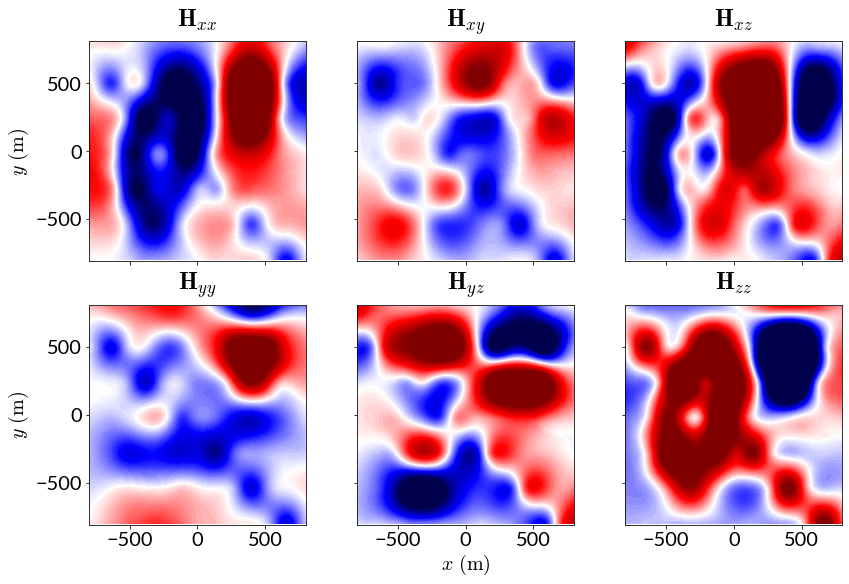

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharey=True, sharex=True, layout="constrained")
ax = ax.ravel()
cmax = 15
titles = [r"$\mathbf{H}_{xx}$", r"$\mathbf{H}_{xy}$", r"$\mathbf{H}_{xz}$",
          r"$\mathbf{H}_{yy}$", r"$\mathbf{H}_{yz}$", r"$\mathbf{H}_{zz}$"]
cmap = "seismic"

for i in range(6):
    if False:
        ax[i].contourf(x_mesh, y_mesh, np.sum(B_init_i[:, (0, 3, 5)], axis=1).reshape(xg.shape),
                       np.linspace(-cmax, cmax, 100), cmap=cmap, extend="both")
    else:  
        ax[i].contourf(x_mesh, y_mesh, (rbf_grid[:, i]).reshape(shape).T, np.linspace(-cmax, cmax, 100), cmap="seismic", extend="both")
    
    ax[i].set_ylim([-810, 810])
    ax[i].set_title(titles[i], pad=15)
    if i == 0 or i == 3:
        ax[i].set_ylabel(r"$y\ (\mathrm{m})$")
    if i == 4:
        ax[i].set_xlabel(r"$x\ (\mathrm{m})$")
    ax[i].set_aspect("equal")

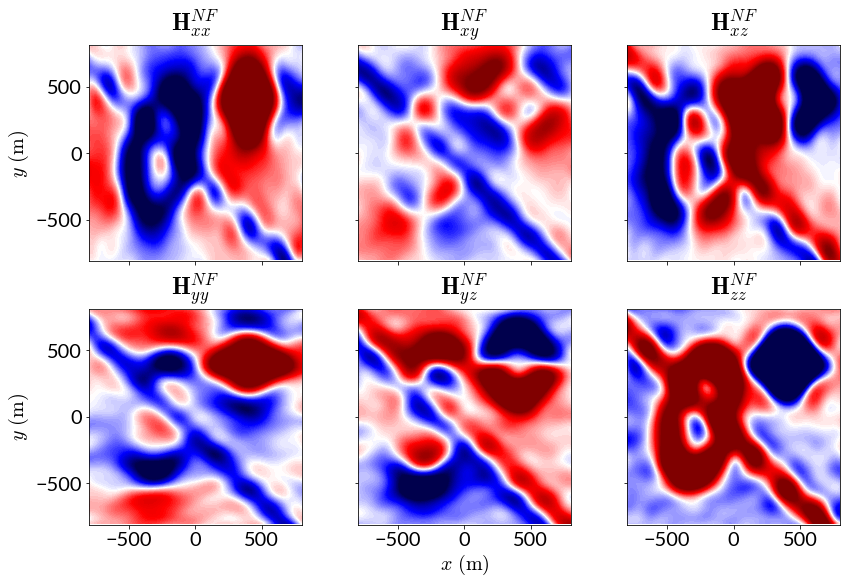

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharey=True, sharex=True, layout="constrained")
ax = ax.ravel()
cmax = 15
titles = [r"$\mathbf{H}^{NF}_{xx}$", r"$\mathbf{H}^{NF}_{xy}$", r"$\mathbf{H}^{NF}_{xz}$",
          r"$\mathbf{H}^{NF}_{yy}$", r"$\mathbf{H}^{NF}_{yz}$", r"$\mathbf{H}^{NF}_{zz}$"]
cmap = "seismic"

for i in range(6):
    if False:
        ax[i].contourf(x_mesh, y_mesh, np.sum(B_init_i[:, (0, 3, 5)], axis=1).reshape(xg.shape),
                       np.linspace(-cmax, cmax, 100), cmap=cmap, extend="both")
    else:  
        ax[i].contourf(x_mesh, y_mesh, (B_init_i[:, i]).reshape(shape).T, np.linspace(-cmax, cmax, 100), cmap="seismic", extend="both")
    
    ax[i].set_ylim([-810, 810])
    ax[i].set_title(titles[i], pad=15)
    if i == 0 or i == 3:
        ax[i].set_ylabel(r"$y\ (\mathrm{m})$")
    if i == 4:
        ax[i].set_xlabel(r"$x\ (\mathrm{m})$")
    ax[i].set_aspect("equal")